# Topic Modeling PubMed Abstracts with Latent Dirichlet Analysis
## bigrams

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# !pip install gensim==3.8.3

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [5]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [6]:
filename = '../data/pubmed_cleaned_no_outliers.csv'

In [7]:
#read in the data
df = pd.read_csv(filename).set_index('pmid')

In [8]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'date', 'citations', 'len_text',
       'len_title', 'days_live'],
      dtype='object')

In [9]:
#remove non-text, non-Y columns
df.drop(columns = ['Unnamed: 0', 'date', 'len_text', 'len_title', 'days_live'], inplace=True)

#### Combine Title & Abstract

In [10]:
df['text'] = (df['title'] + ' ' + df['text'])

In [11]:
df = df.drop(columns = 'title')

#### Remove Punctuation & Make Lowercase

In [12]:
df['text'] = df['text'].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

In [13]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [17]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [18]:
#!spacy download en_core_web_lg

In [19]:
nlp = spacy.load('en_core_web_lg')

In [20]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [21]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [22]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [23]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Bigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
#check out the dictionary

id2word[0]

'advance'

### Build an LDA Model

Start with standard gensim LDA model

In [23]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
doc_lda = lda_model[corpus]

### Evaluate Topic Model

#### Compute Model Perplexity and Coherence Score

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.143508666333588

Coherence Score:  0.4551167178346174


Recent studies have "shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated."[*source*](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Perplexity%20as%20well%20is%20one,used%20for%20language%20model%20evaluation.&text=The%20concept%20of%20topic%20coherence,topics%20inferred%20by%20a%20model.) 

To put it plainly - optimizing for perplexity will not optimize for human interpretability, so in keeping with the spirit of this investigation, I will focus on coherence score to evaluate topic quality. 

Baseline coherence score is 0.455 with gensim's standard LDA algorithm, but the literature indicates that the LDA mallet algorithm may perform better. 

#### Visualize

In [26]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_LDA_10_bigrams.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.291308  0.023599       1        1  48.571511
8     -0.240829  0.175613       2        1  16.721645
9     -0.217817  0.033664       3        1  15.724434
5     -0.120320 -0.257396       4        1   7.531147
4      0.009206 -0.236134       5        1   5.606778
1      0.074525  0.199062       6        1   2.106277
7      0.177436 -0.014080       7        1   1.691089
3      0.206492  0.023884       8        1   0.907227
0      0.203902  0.027888       9        1   0.760618
6      0.198712  0.023899      10        1   0.379273, topic_info=              Term         Freq        Total Category  logprob  loglift
2549          deep  1088.000000  1088.000000  Default  30.0000  30.0000
356          model  2318.000000  2318.000000  Default  29.0000  29.0000
302        patient  1706.000000  1706.000000  Default  28.0000  28.0000
76          method  2584.000000  2584.000000  Default  27.0000  27.0000
30            data  4078.000000  4078.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4409         scene     5.326687     6.134257  Topic10  -5.4431   5.4335
895        firstly     4.886796     5.694442  Topic10  -5.5293   5.4217
954   reproduction     4.408696     5.216455  Topic10  -5.6322   5.4064
1200        neuron    12.662290    34.979489  Topic10  -4.5772   4.5585
3706    multiscale     6.772130    19.451460  Topic10  -5.2030   4.5196

[485 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
11931      7  0.975355       abiotic
2962       4  0.996782      abstract
3481      10  0.948566  accumulation
2138       3  0.993983            ad
622        1  0.995957       address
...      ...       ...           ...
922       10  0.873051       website
4580       7  0.986669          wild
1052       1  0.597108     worldwide
1052       7  0.401691     worldwide
3870       6  0.971050         yeast

[643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 10, 6, 5, 2, 8, 4, 1, 7])

There is lots of overlap and clustering of topics on the left side of the axes. I will try the Mallet algorithm next to improve topic quality.

### Build LDA Mallet Model

In [27]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [28]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [29]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4462227450005294


Coherence score has declined slightly for this 10 topic model using the MALLET algorithm, but if the topic spread looks better, I will continue to use it for varying numbers of topics as the literature indicates this is a better approach than gensim's inbuilt algorithm.

In [3]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [33]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.143295  0.012257       1        1   9.918575
1      0.220014  0.019053       2        1   9.654064
2      0.110440 -0.249092       3        1  10.696750
3     -0.205504 -0.078767       4        1   9.932999
4      0.225625  0.186662       5        1  10.161859
5     -0.039792  0.033220       6        1   9.627819
6      0.014045 -0.240630       7        1   9.967742
7     -0.112222  0.106370       8        1   9.623439
8     -0.120299  0.256649       9        1  10.179656
9     -0.235603 -0.045722      10        1  10.237097, topic_info=          Term         Freq        Total Category  logprob  loglift
30        data  4490.000000  4490.000000  Default  30.0000  30.0000
71     machine  4337.000000  4337.000000  Default  29.0000  29.0000
201   learning  3031.000000  3031.000000  Default  28.0000  28.0000
68       learn  2393.000000  2393.000000  Default  27.0000  27.0000
108      study  2479.000000  2479.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
553      early   175.820230   433.790124  Topic10  -5.2418   1.3761
83   potential   211.831598  1145.476595  Topic10  -5.0555   0.5914
61     include   216.068241  1423.401543  Topic10  -5.0357   0.3939
81     pattern   151.459590   318.691077  Topic10  -5.3910   1.5352
4     approach   170.524435  2237.014797  Topic10  -5.2724  -0.2949

[853 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
399       5  0.755315   ability
399      10  0.246859   ability
2962      3  0.994210  abstract
2023      9  1.001308    access
468       3  0.996833    accord
...     ...       ...       ...
465       3  0.074397      work
465       8  0.507077      work
645       9  1.002226     world
597       2  0.874456      year
597       5  0.124922      year

[1160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The spread of topics has improved for the 10 topic model, but there's a lot of overlap. I will continue using the Mallet algorithm and search over a range of #s of topics to settle on the optimal number, using 
1) coherence score 
2) qualitative evaluation of topic spread/overlap 

as my evaluation metrics.

#### Compute Optimal Number of Topics Based on Coherence

In [34]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_big.pkl')
        joblib.dump(id2word,f'stored_models/id2word_dictionary_mallet{num_topics}_big.pkl')

    return model_list, coherence_values, num_topics_list

In [35]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_bigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [36]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_big.pkl')
joblib.dump(optimal_model,f'stored_models/optimal_ldamallet_model_big.pkl')

['stored_models/optimal_ldamallet_model_big.pkl']

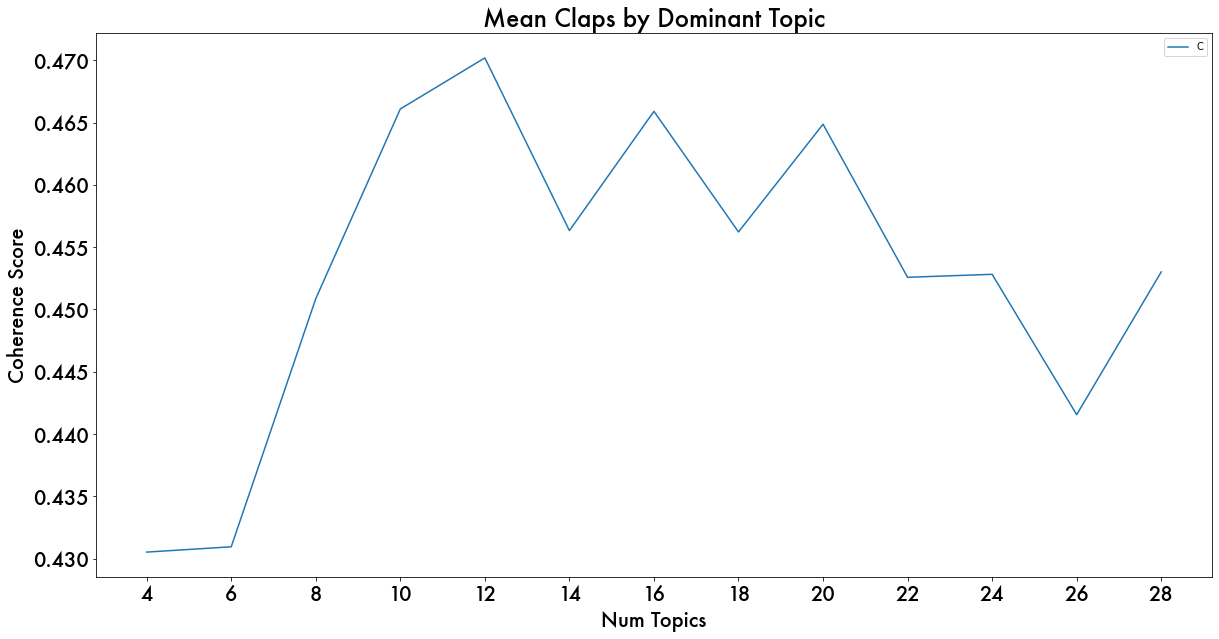

In [40]:
# Show coherence values graph

limit=30; start=4; step=2;
x = range(start, limit, step)
plt.figure(figsize = (20, 10));
sns.lineplot(x=x, y=coherence_values);
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(ticks=range(4,30,2), **figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Num Topics',**figurefont, fontsize = 20);
plt.ylabel('Coherence Score',**figurefont, fontsize = 20);
plt.legend('Coherence Values', loc='best')

plt.savefig('../figures/pubmed_coherence_bigrams.jpg',  bbox_inches = "tight")

The coherence peaks at 12 topics.

### Create & Visualize Model with Optimal Number of Topics

In [25]:
optimal_model = joblib.load('stored_models/optimal_ldamallet_model_big.pkl')

#### LDA Mallet Model: 12 Topics

In [26]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47019433947059514


In [27]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_optimal_LDA_mallet_model12_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.017188 -0.030977       1        1  8.023272
1      0.165449 -0.116490       2        1  7.848003
2      0.136991  0.047598       3        1  8.785019
3     -0.205875 -0.223166       4        1  8.367319
4      0.021433 -0.208487       5        1  8.054702
5      0.054183  0.168561       6        1  8.182156
6     -0.058977  0.095686       7        1  8.290141
7      0.009164  0.046208       8        1  8.440483
8      0.262915 -0.117613       9        1  8.475370
9     -0.262179 -0.051481      10        1  8.092610
10     0.074060  0.239077      11        1  8.491932
11    -0.214351  0.151085      12        1  8.948992, topic_info=                Term         Freq        Total Category  logprob  loglift
71           machine  4292.000000  4292.000000  Default  30.0000  30.0000
30              data  4353.000000  4353.000000  Default  29.0000  29.0000
201         learning  3013.000000  3013.000000  Default  28.0000  28.0000
68             learn  2394.000000  2394.000000  Default  27.0000  27.0000
356            model  2353.000000  2353.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1035  implementation   144.026941   299.562665  Topic12  -5.3068   1.6813
91           provide   225.744349  1613.285662  Topic12  -4.8574   0.4470
61           include   208.379405  1426.537970  Topic12  -4.9375   0.4900
63       information   153.220142   833.181731  Topic12  -5.2450   0.7203
449          require   146.069873   478.372682  Topic12  -5.2927   1.2273

[987 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
399       4  0.347555      ability
399      11  0.651208      ability
2962      3  0.993657     abstract
599      11  0.971242  accommodate
163       6  0.087881     accuracy
...     ...       ...          ...
597       1  0.112482         year
597       3  0.233891         year
597       4  0.169615         year
597       5  0.108911         year
597      11  0.373154         year

[1381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

Decent distribution across the space; not too much overlap.

### Find the Dominant Topic in Each Document

In [28]:
pd.set_option('max_colwidth', 100)

In [29]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_bigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [30]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_bigrams)

df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [31]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,5.0,0.1417,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,7.0,0.1816,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,1.0,0.4117,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,1.0,0.3663,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,11.0,0.1854,"data, health, care, ai, artificial_intelligence, big, medicine, technology, clinical, medical","[future, medical, diagnostic, large, digitized, database, electronic_health, record, mandate, am..."


#### Find the most representative document for each topic

In [32]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [33]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
pmid,,,,
31936321,0.0,0.5435,"drug, development, design, model, approach, computational, modeling, target, recent, drug_discovery","[de_novo, design, organic, molecule, polymer, opportunity, challenge, organic, molecule, polymer..."
25756377,1.0,0.5198,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[overview, prediction, protein, dnabinding, site, interaction, protein, dna, play, important, ro..."
31526946,2.0,0.5179,"study, review, research, result, literature, article, method, paper, identify, include","[half, century, computer, method, program, biomedicine, bibliometric, analysis, background, obje..."
33000054,3.0,0.4521,"patient, disease, clinical, risk, outcome, management, assessment, improve, treatment, cardiovas...","[predict, cardiac_arrest, emergency_department, inhospital, cardiac_arrest, remain, lead, cause,..."
29705713,4.0,0.5407,"study, brain, biomarker, disorder, disease, individual, approach, identify, pattern, functional","[neural, marker, mri, differentiate, depression, panic_disorder, depression, panic_disorder, pd,..."
30337064,5.0,0.4976,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide","[computeraided, diagnosis, glaucoma, fundus, image, review, background, objective, glaucoma, eye..."
32414188,6.0,0.4987,"system, technology, challenge, sensor, device, review, signal, detection, work, solution","[future, unlicensed, private, unlicensed, network, connect, industry, future, paper, aim, unlock..."
26941766,7.0,0.5031,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene","[change, game, integrative, genomics, probe, virulence, mechanism, stem, rust, pathogen, puccini..."
30654138,8.0,0.5982,"model, method, prediction, performance, base, statistical, accuracy, result, predict, predictive","[extensive, experimental, survey, regression, method, regression, relevant, problem, machine, le..."


#### Explore Relationship Between Dominant Topic and Number of Citations

In [34]:
df.head()

,text,citations
pmid,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10


In [35]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,5.0,0.1417,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,7.0,0.1816,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,1.0,0.4117,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,1.0,0.3663,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,11.0,0.1854,"data, health, care, ai, artificial_intelligence, big, medicine, technology, clinical, medical","[future, medical, diagnostic, large, digitized, database, electronic_health, record, mandate, am..."


In [36]:
#merge on index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [37]:
combined_df.columns

Index(['text', 'citations', 'Document_No', 'Dominant_Topic',
       'Topic_Perc_Contrib', 'Keywords', 'Text'],
      dtype='object')

In [38]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [39]:
combined_df.head()

,text,citations,Dominant_Topic,Topic_Perc_Contrib,Keywords
pmid,,,,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35,5.0,0.1417,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide"
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4,7.0,0.1816,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene"
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19,1.0,0.4117,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide..."
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12,1.0,0.3663,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide..."
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10,11.0,0.1854,"data, health, care, ai, artificial_intelligence, big, medicine, technology, clinical, medical"


In [40]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


In [41]:
#colum order
new_column_order = combined_df.groupby('Dominant_Topic')['citations'].mean().sort_values().index

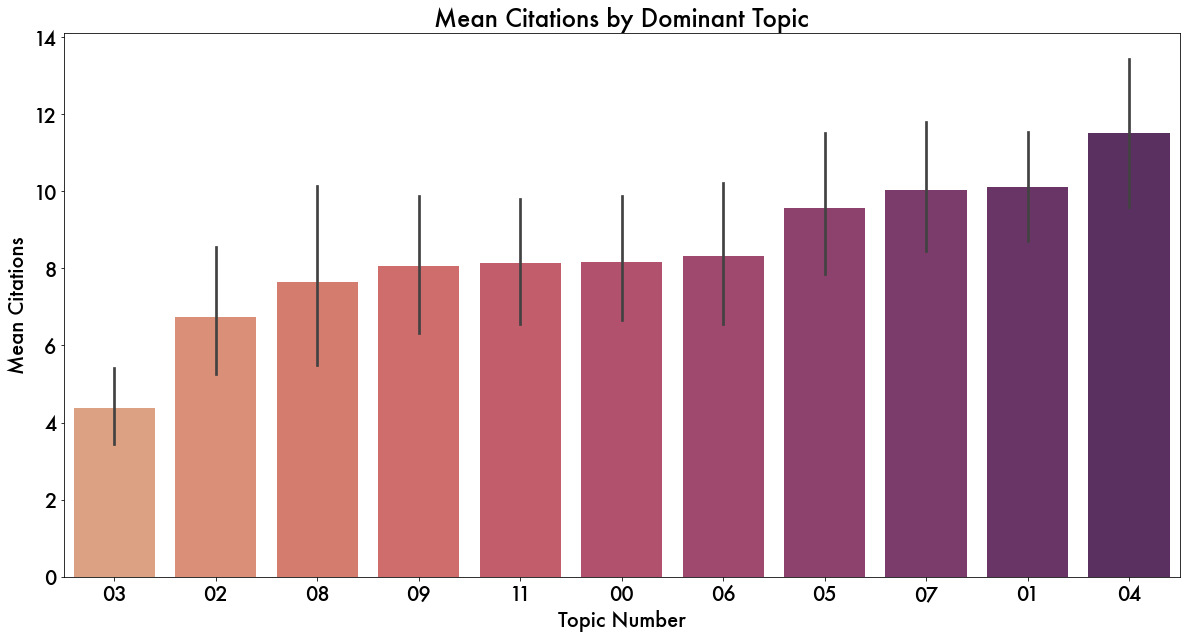

In [42]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='citations', order= new_column_order, palette = 'flare');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Citations by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Citations',**figurefont, fontsize = 20);
plt.savefig('../figures/pubmed_mean_citations_bigram_model12.jpg',  bbox_inches = "tight")

#### Model Citations by Topic

In [43]:
model_df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [44]:
model_df.columns

Index(['text', 'citations', 'Topic_Perc_Contrib', 'Keywords',
       'Dominant_Topic_01', 'Dominant_Topic_02', 'Dominant_Topic_03',
       'Dominant_Topic_04', 'Dominant_Topic_05', 'Dominant_Topic_06',
       'Dominant_Topic_07', 'Dominant_Topic_08', 'Dominant_Topic_09',
       'Dominant_Topic_11'],
      dtype='object')

In [45]:
import statsmodels.api as sm

In [46]:
model_df.head()

,text,citations,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,Dominant_Topic_07,Dominant_Topic_08,Dominant_Topic_09,Dominant_Topic_11
pmid,,,,,,,,,,,,,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35,0.1417,"image, imaging, deep, technique, analysis, diagnosis, review, medical, learning, provide",0,0,0,0,1,0,0,0,0,0
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4,0.1816,"data, analysis, approach, cell, biological, network, genetic, complex, genomic, gene",0,0,0,0,0,0,1,0,0,0
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19,0.4117,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...",1,0,0,0,0,0,0,0,0,0
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12,0.3663,"method, prediction, computational, protein, tool, interaction, approach, function, sequence, ide...",1,0,0,0,0,0,0,0,0,0
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10,0.1854,"data, health, care, ai, artificial_intelligence, big, medicine, technology, clinical, medical",0,0,0,0,0,0,0,0,0,1


In [47]:
X = model_df.drop(columns=['text','citations','Keywords', 'Topic_Perc_Contrib'])
X = sm.add_constant(X, prepend=True)
y = model_df['citations']

In [48]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              citations   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.414
Date:                Wed, 12 May 2021   Prob (F-statistic):           3.49e-06
Time:                        09:57:26   Log-Likelihood:                -11412.
No. Observations:                2809   AIC:                         2.285e+04
Df Residuals:                    2798   BIC:                         2.291e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.1720      0.844      9.687      0.000       6.518       9.826
Dominant_Topic_01     1.9313      1.076      1.795      0.073      -0.179       4.041
Dominant_Topic_02    -1.4205      1.384     -1.026      0.305      -4.134       1.293
Dominant_Topic_03    -3.8051      1.274     -2.987      0.003      -6.303      -1.307
Dominant_Topic_04     3.3518      1.225      2.737      0.006       0.951       5.753
Dominant_Topic_05     1.3856      1.204      1.151      0.250      -0.975       3.747
Dominant_Topic_06     0.1526      1.253      0.122      0.903      -2.305       2.611
Dominant_Topic_07     1.8525      1.187      1.561      0.119      -0.474       4.180
Dominant_Topic_08    -0.5227      1.415     -0.370      0.712      -3.296       2.251
Dominant_Topic_09    -0.1057      1.261     -0.084      0.933      -2.578       2.367
Dominant_Topic_11    -0.0352      1.187     -0.030      0.976      -2.362       2.292
==============================================================================
Omnibus:                     1944.468   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24249.074
Skew:                           3.241   Prob(JB):                         0.00
Kurtosis:                      15.852   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As one might expect, there is quite a bit more going on here beyond just the dominant topic in an abstract. Topic 3 and Topic 4